<a href="https://colab.research.google.com/github/Luke-Mason/DeepLearningA1/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile
from  IPython import display
import math
from sklearn import preprocessing
import tensorflow.keras as keras
from scipy.ndimage.interpolation import rotate, shift
from tensorflow.keras import layers
from shutil import copy2
!pip install tensorflow-addons
import tensorflow_addons as tfa

import struct
from keras.layers.merge import add, concatenate
import argparse
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from scipy.interpolate import interp1d
import random
import cv2
import matplotlib.patches as patches
from google.colab import drive

# Mount Drive

In [ ]:
# Mount the google drive to get the imagery data and get any saved models previously.
drive.mount('/content/drive', force_remount=True)

# Change according to your directory structure
!cp /content/drive/'My Drive'/DL/Distance_dataset.zip .
!unzip -q -o Distance_dataset.zip
!rm Distance_dataset.zip
!ls

# Load the csv data, which contains references to the imagery data.
data = pd.read_csv('./data_updated.csv', delimiter=',')

# EDA

In [9]:
data.head()

,file_path,distance,scene,personID,xmax,xmin,ymax,ymin
0,Images/07_OUTSIDE_1198.png,14.9,OUTSIDE,7,323.16498,313.81473,201.65112,170.32014
1,Images/01_OUTSIDE_3420.png,6.7,OUTSIDE,1,333.87970,297.28207,249.00247,165.39919
2,Images/11_OUTSIDE_5506.png,7.3,OUTSIDE,11,169.90585,145.17395,231.83516,165.30717
3,Images/06_OUTSIDE_3869.png,7.9,OUTSIDE,6,369.01447,349.55515,234.96034,174.08122
4,Images/06_OUTSIDE_3952.png,7.5,OUTSIDE,6,317.37772,293.60165,240.42155,172.18889


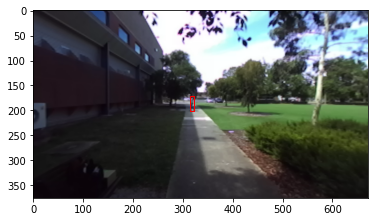

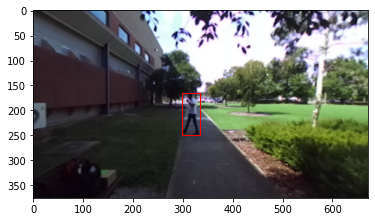

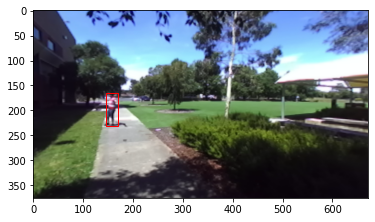

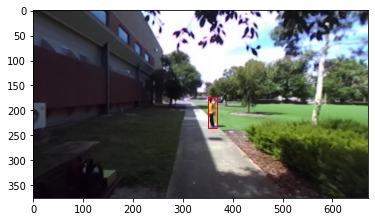

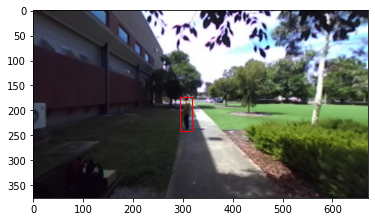

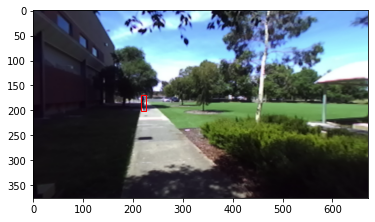

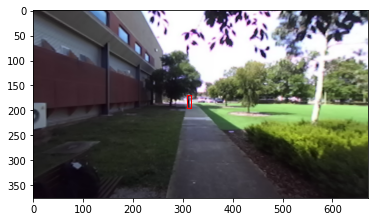

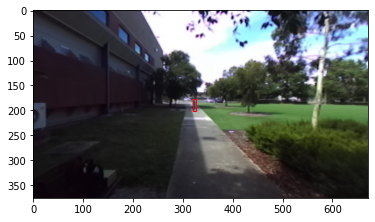

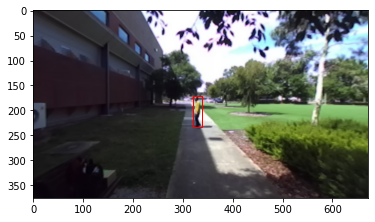

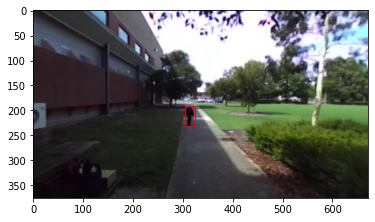

In [20]:
samples = 10

for index, row in data.iterrows():
  if index >= samples:
    continue

  img = np.asarray(Image.open('./' + row["file_path"]))
  xmax = row["xmax"]
  ymax = row["ymax"]
  xmin = row["xmin"]
  ymin = row["ymin"]

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

  # Create figure and axes
  fig, ax = plt.subplots()

  # Add the patch to the Axes
  ax.add_patch(rect)

  # Display the image
  ax.imshow(img)

# Split Data

In [ ]:
# Split the data
train_set, validation_set, test_set = 

# Data Generator

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, data_mean=0, data_std=1, directory='', shuffle=True, augmentations=dict(), seed=30):
        'Initialization'

        self.n_classes = n_classes  # Number of classes. This is for a classification task

        # Generates a reproducable series of numbers from generation that are then given as a seed to the numpy shuffler.
        self.random =  random.seed(seed);

        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame

        # Initialise the image labels into a list from the data frame.
        self.image_labels = data_frame[['action_num', 'action_class_num']].values.tolist() 

        # Used as the file path to the folder containing the images.
        self.directory = directory
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std

        # Calculate the number of batcher per epoch and the ids for each batch.
        # Create a batch of ids (row indexes) for each unique resolution.
        batch_ids = []
        resolutions = self.data_frame['resolution'].unique()
        for unique_resolution in resolutions:

          # The ids to include in the batch are the ones that match the resolution exactly.
          ids = self.data_frame.loc[self.data_frame['resolution'] == unique_resolution]["index"].values.tolist()

          # break up ids into groups if they surpass batch size
          batch_ids = batch_ids + list(self.__chunks__(ids, batch_size))
        
        self.batch_ids = batch_ids

        # Set the augmentation set to calculate all augmentation permutations and apply them to to the batch of data effectively multiplying the amount of data.
        self.augmentations = augmentations
        
        # Shuffle the data before the start of the epoch.
        self.on_epoch_end()

    def __chunks__(self, lst, n):
      """Yield successive n-sized chunks from lst."""
      for i in range(0, len(lst), n):
          yield lst[i:i + n]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.batch_ids)

    def __getitem__(self, index):
        'Generate one batch of data for the given index'

        # Generate indexes of the batch
        ids = self.shuffled_batch_ids[index]

        # Generate data
        X, y = self.__data_generation(ids)
        
        return X, y

    def on_epoch_end(self):
        'Updates batch ordering after each epoch'
        self.shuffled_batch_ids = self.batch_ids
        if self.shuffle == True:

          # Create random seed from the random generator that is seeded.
          np.random.seed(self.random)
          
          # Shuffle the group ordering
          np.random.shuffle(self.shuffled_batch_ids)

          # Shuffle each group
          for group in self.shuffled_batch_ids:
            np.random.shuffle(group)
  
  
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    # Support function
    def __data_generation(self, batch_indices):
        'Generates data containing batch_size samples' 
        
        # Get resolution for the batch of ids (they all have same resolution).
        resolution_dim = self.data_frame.iloc[batch_indices[0]]["resolution_dim"]
        
        # Initialization
        X = np.empty((len(batch_indices), *resolution_dim))
        action_labels = list()
        action_class_labels = list()

        # Generate data
        for i, row_index in enumerate(batch_indices):
            y1_label = self.image_labels[row_index][0]
            y2_label = self.image_labels[row_index][1]

            y1_hot = keras.utils.to_categorical(y1_label, num_classes=21)
            y2_hot = keras.utils.to_categorical(y2_label, num_classes=5)

            action_labels.append(y1_hot)
            action_class_labels.append(y2_hot)

            X[i,] = self.__read_data_instance(row_index, resolution_dim)

        action_labels = np.array(action_labels)
        action_class_labels = np.array(action_class_labels)

        return X, tuple([action_labels, action_class_labels])

    def __read_data_instance(self, row_index, dims):
      'Gets the image data from the row index, and can augment the pixels values if True, and apply normalisation'

      # Get the file name of the image at row index
      row = self.data_frame.iloc[row_index]

      filepath = self.directory + row['FileName']
      img = Image.open(filepath)
      img = np.asarray(img)

      # Augment the data if there are augmentation methods given.
      if len(self.augmentations) > 0:
          for aug in self.augmentations:
            if np.random.rand(1) < 0.5:
              img = aug(img)
      
      img = np.array(img)

      # Input normalization, making pixel values between 0..1
      img = img - self.data_mean
      img = img / self.data_std

      return img

In [ ]:
# Define the generators
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set.head(1), data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

In [ ]:
INIT_LR = 0.001
NUM_EPOCHS = 25
BATCH_SIZE = 32
METRICS_CI = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',curve='ROC',),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  INIT_LR,
  decay_steps=train_generator.__len__() * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.MeanSquaredError(),
    "metrics": METRICS_CI,

    # Generator Parameters.
    "batch_size": BATCH_SIZE,

    # Fit perameters.
    "epochs": NUM_EPOCHS
}

# reg_lambda = 0.001

# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.InceptionV3(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

# flatten the max-pooling output of InceptionV3
x = base_model.output
x = Flatten()(x)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(x)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)

# 4 Neurons for the 4 bounding box coordinates.
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=base_model.input, outputs=bboxHead)
model.summary()
model_name = "test"

In [ ]:
history, model = run_model(model, parameters, model_name, train_generator, val_generator)

In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
                
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            cv2.putText(image, 
                        label_str + ' ' + str(box.get_score()), 
                        (box.xmin, box.ymin - 13), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1e-3 * image.shape[0], 
                        (0,255,0), 2)
        
    return image 

In [6]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

[YOLOv3 Architecture](https://miro.medium.com/max/1200/1*d4Eg17IVJ0L41e7CTWLLSg.png)

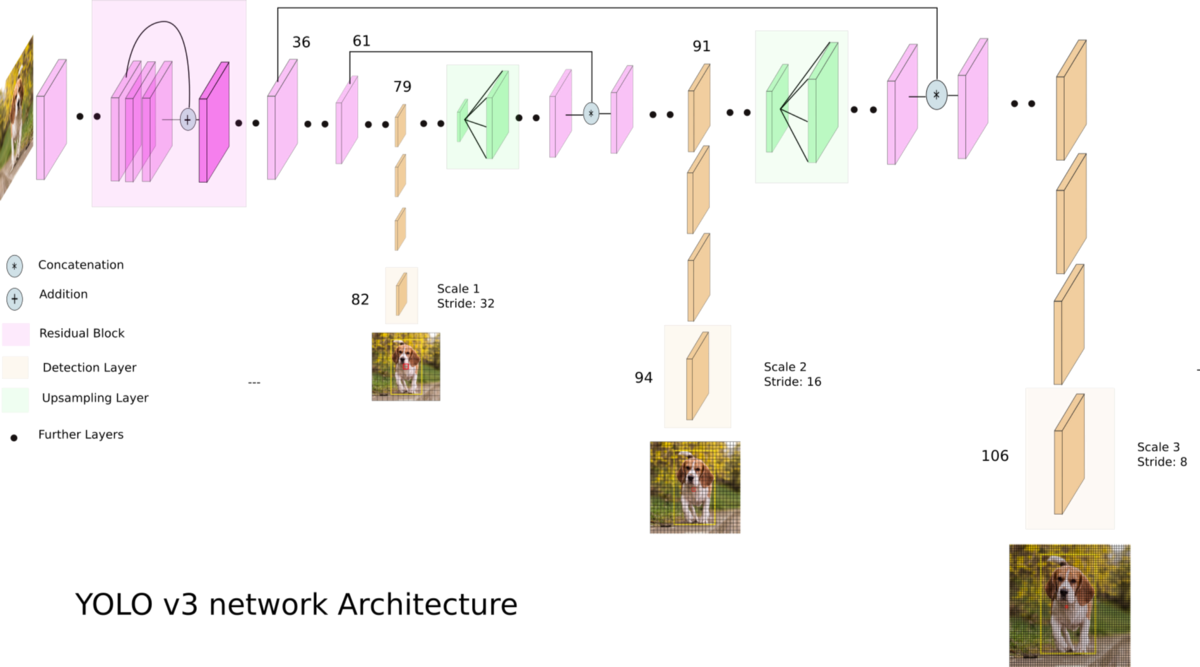

In [ ]:
weights_path = "/DL/yolov3.weights"



# make the yolov3 model to predict 80 classes on COCO.
yolov3 = make_yolov3_model()

# load the weights trained on COCO into the model.
weight_reader = WeightReader(weights_path)
weight_reader.load_weights(yolov3)

In [7]:
image_path   = "./Images/01_INSIDE_00044.png"

# set some parameters
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person"]
# , "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
#           "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
#           "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
#           "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
#           "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
#           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
#           "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
#           "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
#           "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
#           "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# preprocess the image.
image = cv2.imread(image_path)
image_h, image_w, _ = image.shape
new_image = preprocess_input(image, net_h, net_w)

# run the prediction
yolos = yolov3.predict(new_image)
boxes = []

for i in range(len(yolos)):
    # decode the output of the network.
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)     

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh) 

# write the image with bounding boxes to file
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

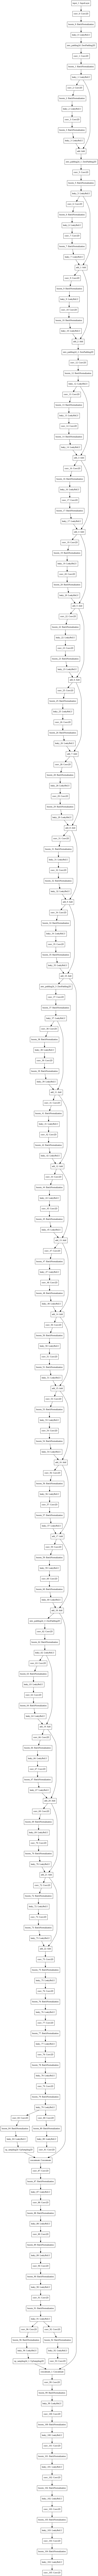

In [8]:
keras.utils.plot_model(model, "yolov3.png")